# **Mandatory notebook 2 - Feature engineering, rules-based models and ensembles (FErules)**

In [1]:
!pip install Wittgenstein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.8/124.8 KB 309.8 kB/s eta 0:00:00


In [2]:
import copy
import seaborn as sns
import pandas as pd
import numpy as np
import os
%matplotlib inline
import wittgenstein as lw
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from sklearn.feature_selection import f_classif, SelectKBest
import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("/kaggle/input/mn1-data/train_mn1.csv")
data_test = pd.read_csv("/kaggle/input/mn1-data/test_mn1.csv")

In [4]:
X = pd.read_csv("../input/mn1transformed/data_avg_new.csv")
X_test = pd.read_csv("../input/mn1transformed/data_test_avg_new.csv")
y = pd.read_csv("../input/mn1transformed/data_y_test.csv")
y_test = pd.read_csv("../input/mn1transformed/data_y_train.csv")

In [5]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)
clf.score(X_test, y_test)

0.640650406504065

In [6]:
y_result = clf.predict(X_test)

# create submission format
submission = data_test.loc[:,data_test.columns.isin(('id', ))]
submission["id"] = submission.index
# add random predictions as 'NEXT_WINNER' column into submission df
submission.loc[:,'NEXT_WINNER'] = y_result

In [7]:
submission.to_csv("submission.csv", index = None)
submission.head()

,id,NEXT_WINNER
0,0,0.0
1,1,0.0
2,2,1.0
3,3,0.0
4,4,0.0


---

# 1. Dataset description

Transformed features represent avarage values of each feature for home or away team. For next_home and nex_away team, we look at all previous games where one of them have played and then take stats from that game of how that team has played and avarage them out. Each game has again 164 features, just like the dataset we have started with, but the values of features are avaraged out based on all previous games played.

# 2. Cross-validation function

In [8]:
def cross_validation_function(X, y):
    gauss_model = GaussianNB()
    log_model = LogisticRegression()
    ripper_model = lw.RIPPER()
    rf_model = RandomForestClassifier()
    et_model = ExtraTreesClassifier()
    xgb_model = XGBClassifier()
    
    models = [gauss_model, log_model, ripper_model, rf_model, et_model, xgb_model]
    scores = []
    
    for model in models:
        score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        scores.append(score)
        
    table = pd.DataFrame(data=scores, columns=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"])
    table.insert(0, "Algorithm", ["GaussianNB", "LogisticRegression", "RIPPER", "RandomForestClassifier", "ExtraTreesClassifier", "XGBClassifier"])
    display(table)

## 3. Run the cross-validation function

In [9]:
cross_validation_function(pd.concat([X, X_test], axis=0),list(map(int, y['0'].values.tolist()+ y_test['0'].values.tolist())))

[21:51:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,Algorithm,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
0,GaussianNB,0.664286,0.431633,0.423902,0.426966,0.440245
1,LogisticRegression,0.657143,0.662245,0.667007,0.685393,0.641471
2,RIPPER,0.579592,0.612245,0.577120,0.601634,0.591420
3,RandomForestClassifier,0.612245,0.645918,0.644535,0.657814,0.636364
4,ExtraTreesClassifier,0.643878,0.652041,0.640449,0.639428,0.643514
5,XGBClassifier,0.622449,0.656122,0.661900,0.639428,0.621042


The table tells us that Logistic Regression gives the best results.

In [10]:
log_model = LogisticRegression()
y_result = log_model.fit(X, y['0'].values.tolist())
log_model.score(X_test, y_test['0'].values.tolist())

0.6317073170731707

**New accuracy score is 63.17%.**

# 4. Correlations

In [11]:
corr = X.corr()
corr

,AST_HOME,AST_PCT_HOME,AST_RATIO_HOME,AST_TOV_HOME,BLKA_HOME,BLK_HOME,CFGA_HOME,CFGM_HOME,CFG_PCT_HOME,DEF_RATING_HOME,...,STL_AWAY,TCHS_AWAY,TEAM_ABBREVIATION_AWAY,TM_TOV_PCT_AWAY,TO_AWAY,TS_PCT_AWAY,UFGA_AWAY,UFGM_AWAY,UFG_PCT_AWAY,USG_PCT_AWAY
AST_HOME,1.000000,0.925481,0.967516,0.766104,-0.011600,0.236028,0.232589,0.391254,0.701635,0.527559,...,0.238622,0.399267,0.065515,0.281456,0.254397,0.464821,0.360378,0.289190,0.422955,0.550197
AST_PCT_HOME,0.925481,1.000000,0.941997,0.705343,0.135781,0.272895,0.281557,0.344144,0.656453,0.615859,...,0.282225,0.466213,0.062021,0.338929,0.304114,0.517109,0.410486,0.330918,0.484891,0.627516
AST_RATIO_HOME,0.967516,0.941997,1.000000,0.794186,-0.047123,0.261376,0.188169,0.356310,0.765212,0.576408,...,0.258214,0.442256,0.063116,0.310976,0.280531,0.503931,0.393783,0.314871,0.461721,0.602656
AST_TOV_HOME,0.766104,0.705343,0.794186,1.000000,-0.143727,0.110964,0.134095,0.231735,0.500117,0.413482,...,0.162335,0.292904,0.049769,0.145080,0.125035,0.352831,0.277707,0.219276,0.310302,0.410329
BLKA_HOME,-0.011600,0.135781,-0.047123,-0.143727,1.000000,0.178219,0.667508,0.480475,0.005519,0.348715,...,0.142235,0.226277,0.021720,0.170181,0.156550,0.243292,0.203011,0.185557,0.254427,0.288509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TS_PCT_AWAY,0.464821,0.517109,0.503931,0.352831,0.243292,0.273340,0.474676,0.498198,0.582960,0.663607,...,0.482559,0.610230,0.108997,0.502878,0.484406,1.000000,0.676507,0.752873,0.935533,0.838389
UFGA_AWAY,0.360378,0.410486,0.393783,0.277707,0.203011,0.233334,0.394816,0.405475,0.462943,0.535454,...,0.325023,0.608200,0.130327,0.227175,0.270742,0.676507,1.000000,0.913101,0.649624,0.683734
UFGM_AWAY,0.289190,0.330918,0.314871,0.219276,0.185557,0.198575,0.328411,0.331603,0.371748,0.437998,...,0.348886,0.476388,0.124325,0.182679,0.222835,0.752873,0.913101,1.000000,0.790368,0.577480
UFG_PCT_AWAY,0.422955,0.484891,0.461721,0.310302,0.254427,0.278834,0.447280,0.454490,0.534773,0.623835,...,0.454225,0.572847,0.106726,0.476765,0.439020,0.935533,0.649624,0.790368,1.000000,0.808969


There are a lot of features so it's hard to detect high correlations from the correlation table. We also can't graph a heatmap for the same reason.

In [12]:
def pairs(X):
    corr = X.corr()
    columns = corr.columns
    high_corr = dict()
    feature_corr_n = dict.fromkeys(X.columns, 0)
    for column1 in columns:
        for column2 in columns:
            value = corr[column1][column2]
            if value > 0.8 and column1 != column2 and (column2, column1) not in high_corr:
                high_corr[(column1,column2)] = value
                feature_corr_n[column1] += 1
                feature_corr_n[column2] += 1
    return high_corr, feature_corr_n

Pairs of features that have correlation > 0.8:

In [13]:
high_corr, feature_corr_n= pairs(X)
high_corr

{('AST_HOME', 'AST_PCT_HOME'): 0.9254812733073805,
 ('AST_HOME', 'AST_RATIO_HOME'): 0.9675160887756684,
 ('AST_HOME', 'PCT_AST_2PM_HOME'): 0.8878482818108013,
 ('AST_HOME', 'PCT_AST_FGM_HOME'): 0.9254812733073805,
 ('AST_PCT_HOME', 'AST_RATIO_HOME'): 0.9419973954319373,
 ('AST_PCT_HOME', 'PCT_AST_2PM_HOME'): 0.9555998746303462,
 ('AST_PCT_HOME', 'PCT_AST_FGM_HOME'): 1.0,
 ('AST_RATIO_HOME', 'EFG_PCT_HOME'): 0.8089362353706522,
 ('AST_RATIO_HOME', 'FG_PCT_HOME'): 0.8046197974080698,
 ('AST_RATIO_HOME', 'PCT_AST_2PM_HOME'): 0.8873214725221821,
 ('AST_RATIO_HOME', 'PCT_AST_FGM_HOME'): 0.9419973954319374,
 ('CFGA_HOME', 'CFGM_HOME'): 0.88796352326326,
 ('CFGM_HOME', 'PCT_PTS_PAINT_HOME'): 0.8523649455847512,
 ('CFGM_HOME', 'PTS_PAINT_HOME'): 0.8879310382494847,
 ('CFG_PCT_HOME', 'EFG_PCT_HOME'): 0.9247736676617393,
 ('CFG_PCT_HOME', 'FGM_HOME'): 0.8578970340711816,
 ('CFG_PCT_HOME', 'FG_PCT_HOME'): 0.9494619150285639,
 ('CFG_PCT_HOME', 'OFF_RATING_HOME'): 0.8831146740884366,
 ('CFG_PCT_HOM

Features that are correlated to more than 5 other features:

In [14]:
for column in X.columns:
    if feature_corr_n[column] > 5:
        print(column+": "+ str(feature_corr_n[column]))

AST_RATIO_HOME: 6
CFG_PCT_HOME: 7
DEF_RATING_HOME: 8
DIST_HOME: 17
DREB_HOME: 8
DREB_PCT_HOME: 16
EFG_PCT_HOME: 12
FGA_HOME: 11
FGM_HOME: 12
FG_PCT_HOME: 13
FT_PCT_HOME: 6
OFF_RATING_HOME: 13
OPP_EFG_PCT_HOME: 7
PACE_HOME: 17
RBC_HOME: 7
REB_HOME: 9
REB_PCT_HOME: 13
TS_PCT_HOME: 14
UFG_PCT_HOME: 12
USG_PCT_HOME: 22
DEF_RATING_AWAY: 6
DIST_AWAY: 10
DREB_AWAY: 6
DREB_PCT_AWAY: 7
EFG_PCT_AWAY: 9
FGA_AWAY: 8
FGM_AWAY: 10
FG_PCT_AWAY: 8
OFF_RATING_AWAY: 10
PACE_AWAY: 11
REB_AWAY: 6
REB_PCT_AWAY: 9
TS_PCT_AWAY: 9
UFG_PCT_AWAY: 8
USG_PCT_AWAY: 18


Groups of features correlated more than 0.8:

{'DIST_HOME', 'REB_PCT_AWAY', 'PASS_HOME', 'REB_AWAY', 'TS_PCT_HOME', 'UFG_PCT_HOME', 'FGM_HOME', 'TS_PCT_AWAY', 'OREB_HOME', 'DREB_HOME', 'FT_PCT_HOME', 'OPP_EFG_PCT_HOME', 'DREB_PCT_AWAY', 'FGA_HOME', 'FGA_AWAY', 'FGM_AWAY', 'OREB_AWAY', 'PTS_2ND_CHANCE_AWAY', 'OFF_RATING_HOME', 'DFG_PCT_HOME', 'PACE_AWAY', 'PACE_HOME', 'USG_PCT_AWAY', 'ORBC_AWAY', 'AST_HOME', 'CFG_PCT_HOME', 'PIE_HOME', 'DREB_PCT_HOME', 'TCHS_HOME', 'REB_PCT_HOME', 'DRBC_HOME', 'USG_PCT_HOME', 'DEF_RATING_AWAY', 'FG_PCT_HOME', 'DFG_PCT_AWAY', 'OFF_RATING_AWAY', 'REB_HOME', 'DFGM_HOME', 'EFG_PCT_AWAY', 'OREB_PCT_HOME', 'FG3_PCT_AWAY', 'AST_RATIO_HOME', 'PIE_AWAY', 'PCT_AST_3PM_AWAY', 'ORBC_HOME', 'PTS_2ND_CHANCE_HOME', 'EFG_PCT_HOME', 'UFGM_HOME', 'DREB_AWAY', 'OPP_PTS_PAINT_HOME', 'FG_PCT_AWAY', 'UFG_PCT_AWAY', 'RBC_HOME', 'DFGA_HOME', 'DEF_RATING_HOME', 'CFG_PCT_AWAY', 'PCT_AST_2PM_HOME', 'PCT_AST_3PM_HOME', 'OPP_EFG_PCT_AWAY', 'OREB_PCT_AWAY', 'DIST_AWAY', 'PCT_AST_FGM_HOME', 'FT_PCT_AWAY', 'TCHS_AWAY', 'DRBC_AWAY

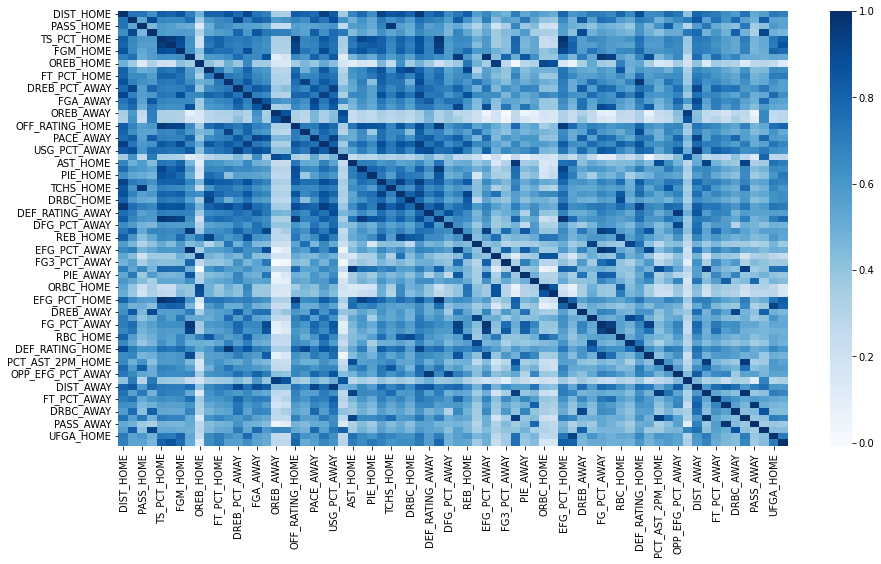

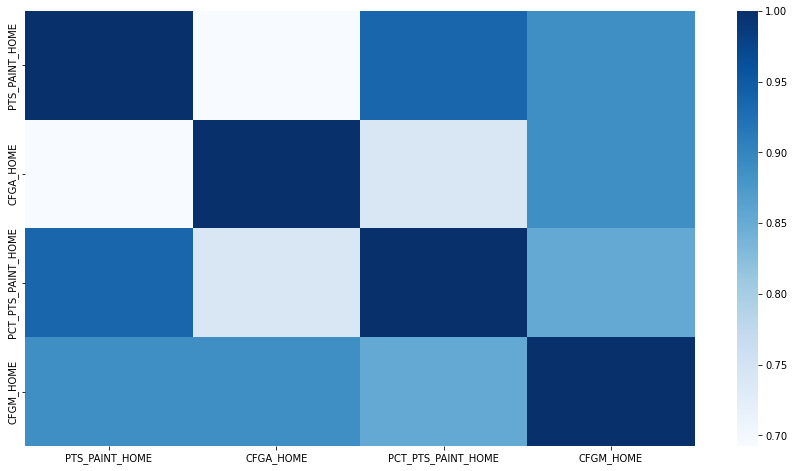

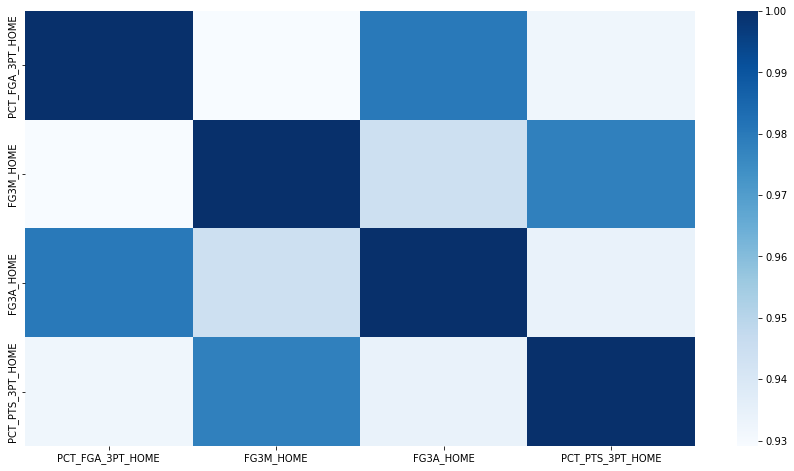

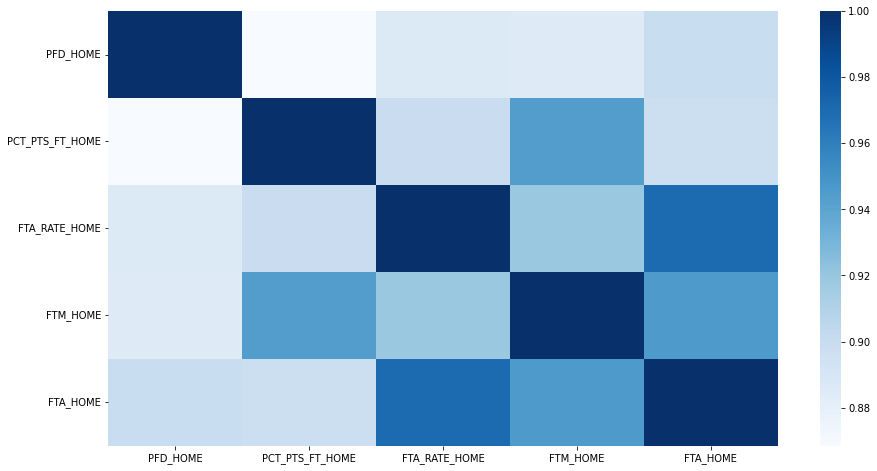

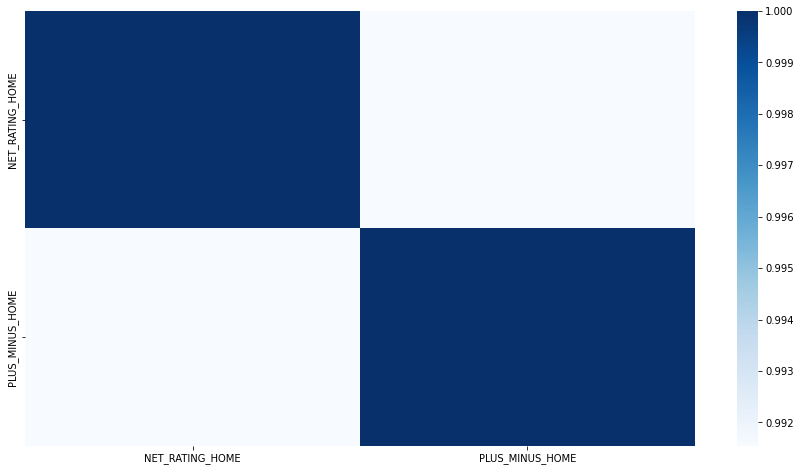

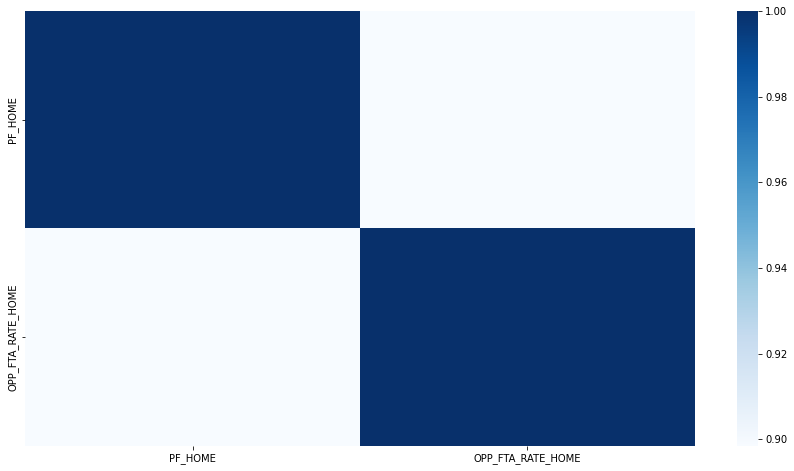

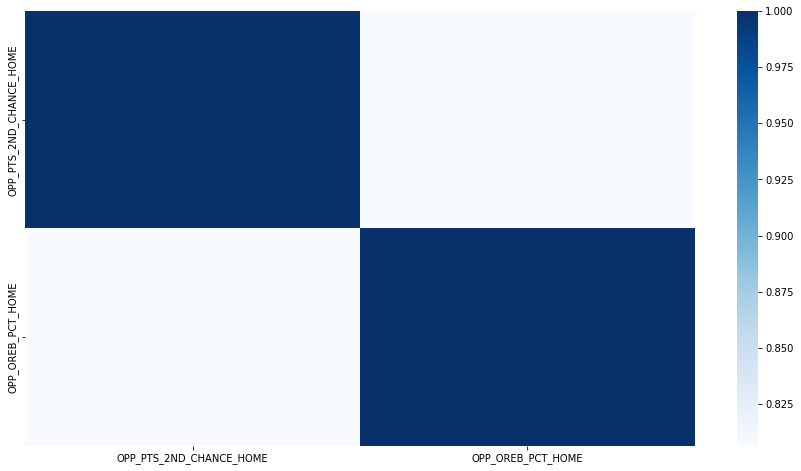

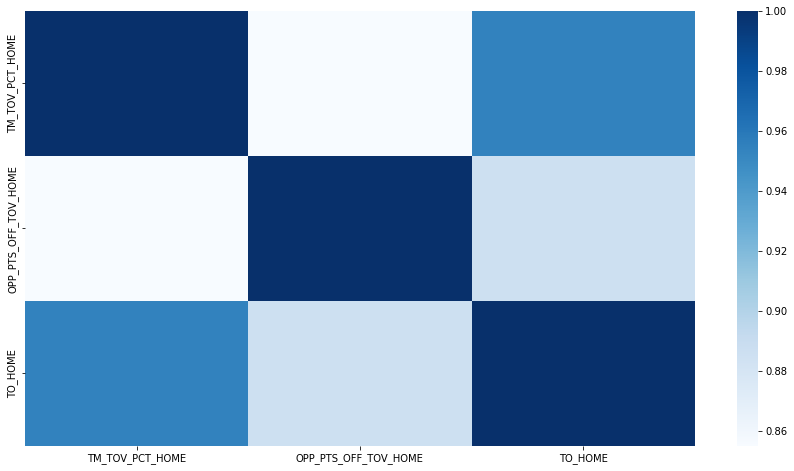

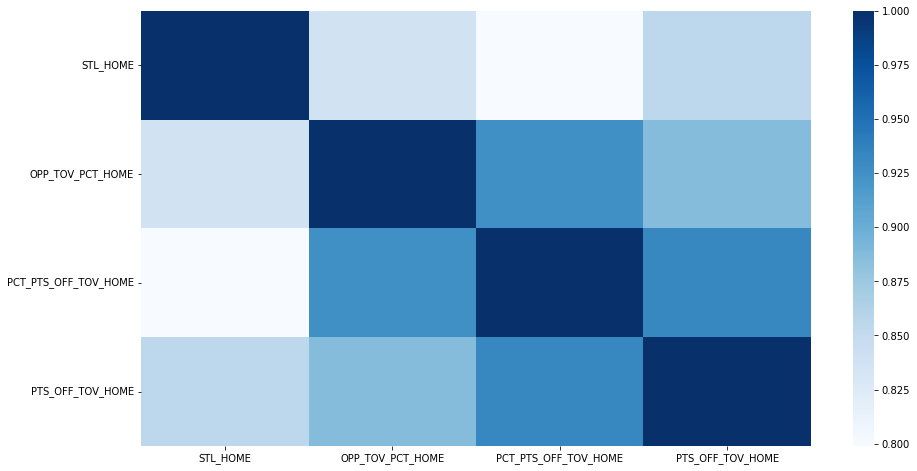

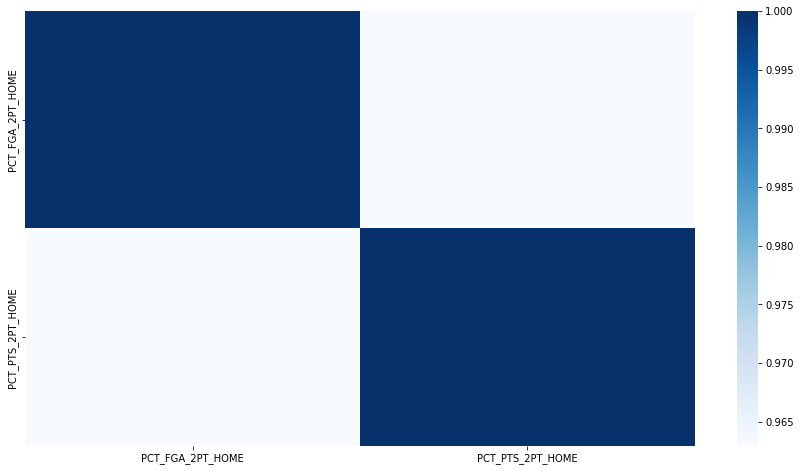

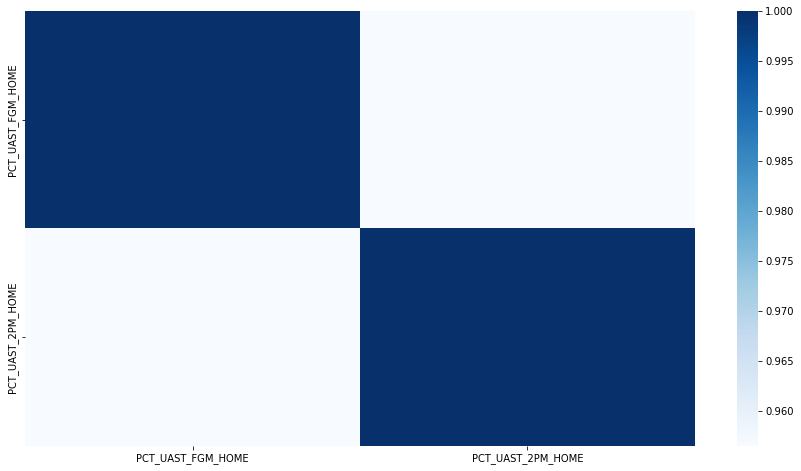

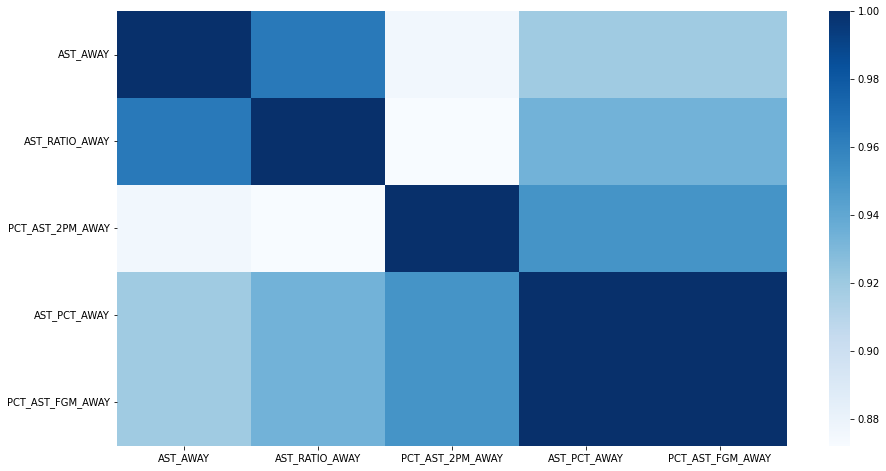

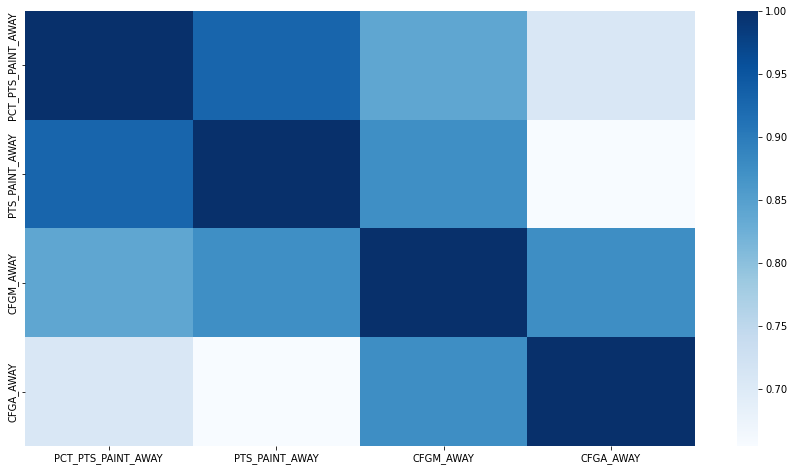

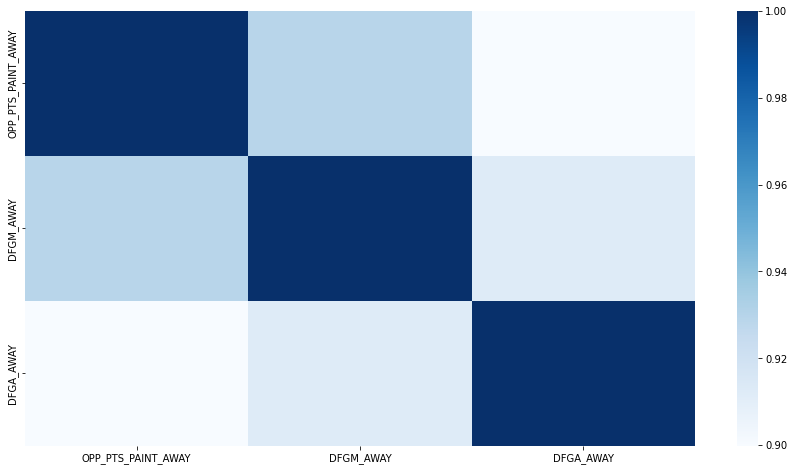

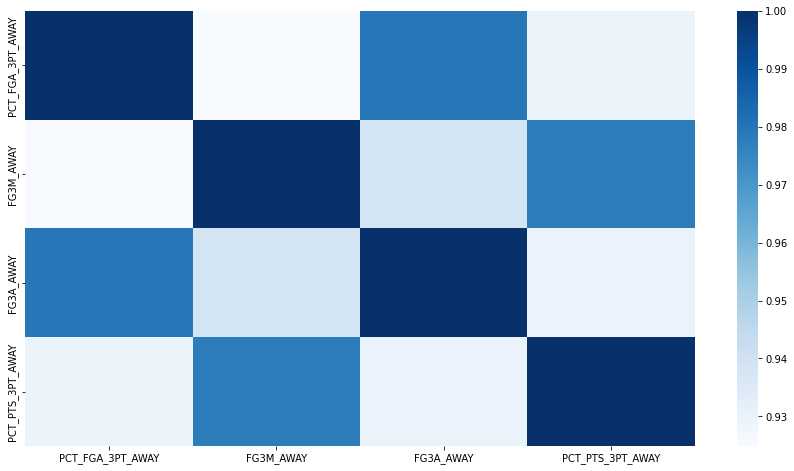

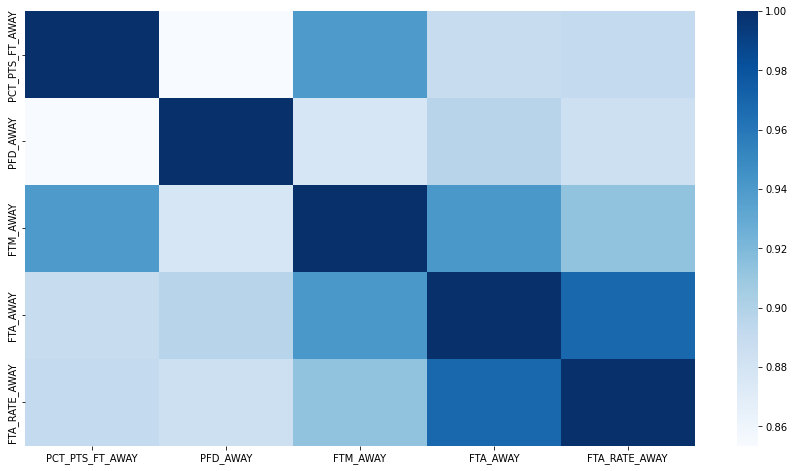

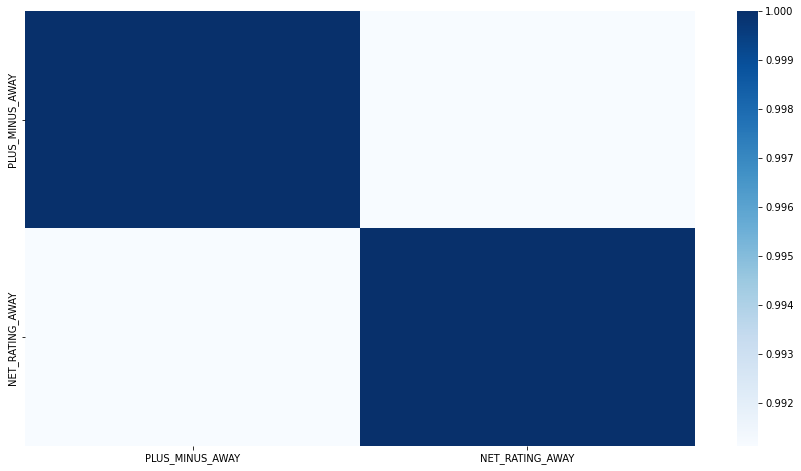

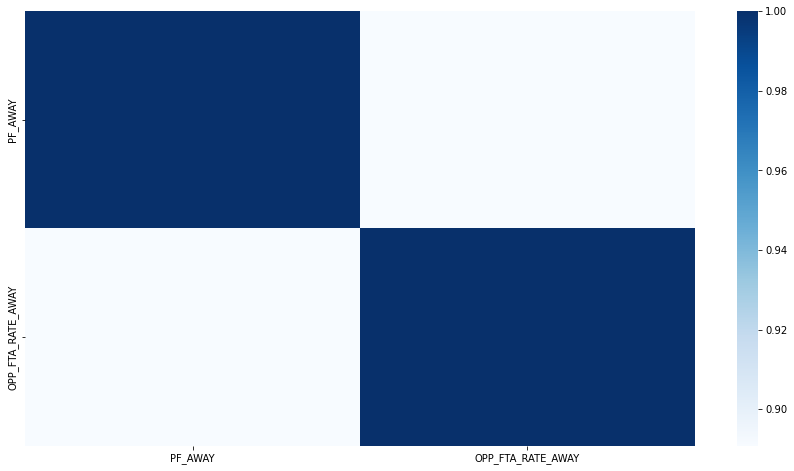

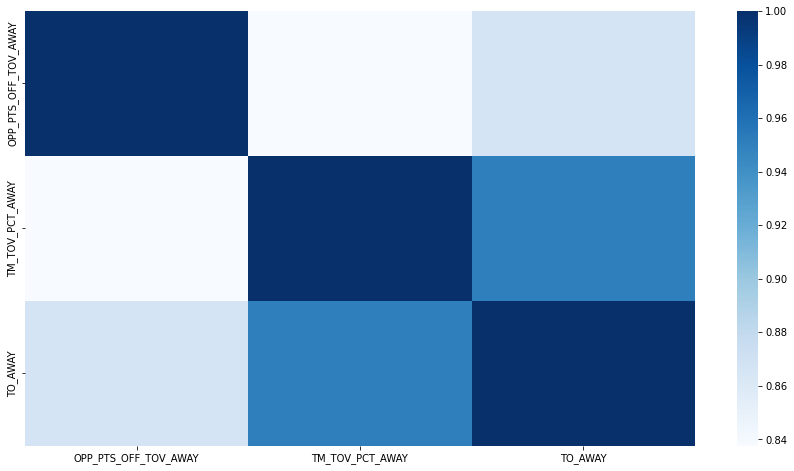

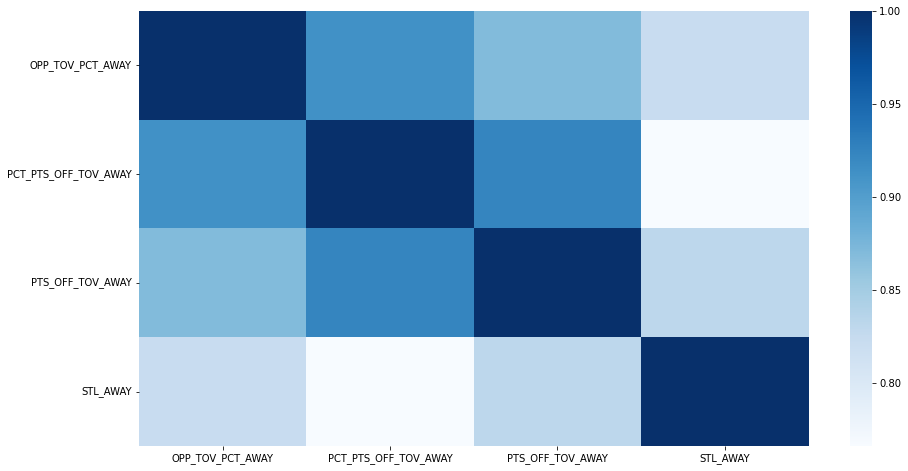

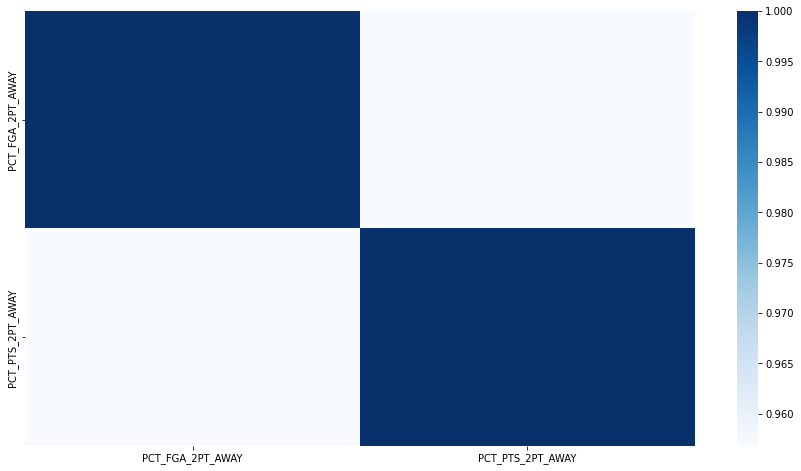

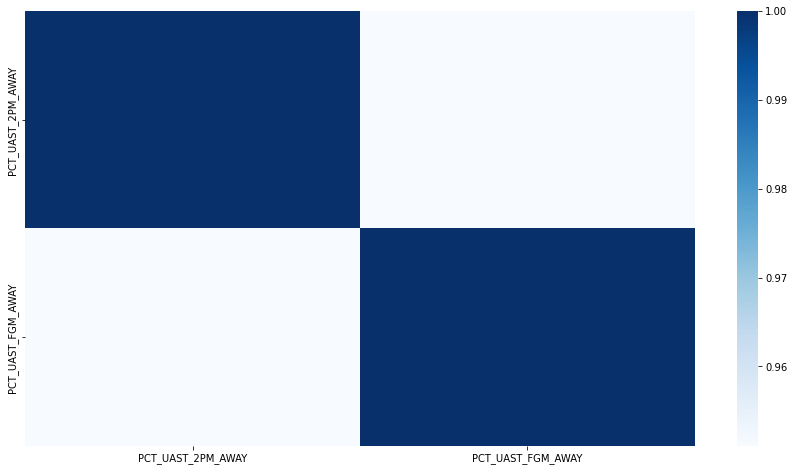

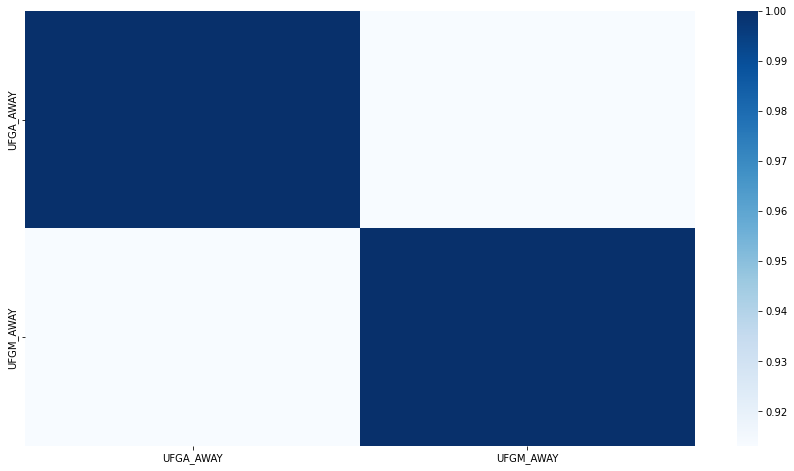

In [15]:
components = list()
visited = set()
for col in X.columns:
    if col in visited:
        continue

    component = set([col, ])
    just_visited = [col, ]
    visited.add(col)
    while just_visited:
        c = just_visited.pop(0)
        for idx, val in corr[c].items():
            if abs(val) > 0.8 and abs(val) != 1 and idx not in visited:
                just_visited.append(idx)
                visited.add(idx)
                component.add(idx)
    components.append(component)

for component in components:
    if len(component) > 1:
        print(component)
        plt.figure(figsize=(15,8))
        sns.heatmap(corr.loc[component, component], cmap="Blues")

From each group we will keep one feature and we will try to choose that feature based on coef in logistic regression model. The higher the coef for feature in the model the more important that feature is to the model outcome.

In [16]:
importance = log_model.coef_[0]


Component:
 Feature: DIST_HOME, Score: -0.00610
 Feature: REB_PCT_AWAY, Score: 0.00026
 Feature: PASS_HOME, Score: -0.03279
 Feature: REB_AWAY, Score: -0.00735
 Feature: TS_PCT_HOME, Score: -0.00006
 Feature: UFG_PCT_HOME, Score: -0.00013
 Feature: FGM_HOME, Score: -0.00309
 Feature: TS_PCT_AWAY, Score: 0.00016
 Feature: OREB_HOME, Score: -0.01186
 Feature: DREB_HOME, Score: -0.01732
 Feature: FT_PCT_HOME, Score: -0.00004
 Feature: OPP_EFG_PCT_HOME, Score: 0.00022
 Feature: DREB_PCT_AWAY, Score: -0.00002
 Feature: FGA_HOME, Score: 0.01196
 Feature: FGA_AWAY, Score: -0.02132
 Feature: FGM_AWAY, Score: 0.01323
 Feature: OREB_AWAY, Score: 0.01326
 Feature: PTS_2ND_CHANCE_AWAY, Score: -0.00528
 Feature: OFF_RATING_HOME, Score: -0.03707
 Feature: DFG_PCT_HOME, Score: 0.00078
 Feature: PACE_AWAY, Score: -0.04199
 Feature: PACE_HOME, Score: 0.03470
 Feature: USG_PCT_AWAY, Score: -0.00002
 Feature: ORBC_AWAY, Score: 0.04561
 Feature: AST_HOME, Score: -0.03028
 Feature: CFG_PCT_HOME, Score: 0.

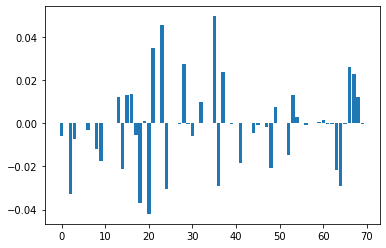


Component:
 Feature: PTS_PAINT_HOME, Score: -0.01981
 Feature: CFGA_HOME, Score: -0.00307
 Feature: PCT_PTS_PAINT_HOME, Score: -0.00003
 Feature: CFGM_HOME, Score: -0.00160


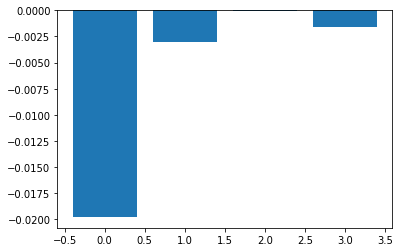


Component:
 Feature: PCT_FGA_3PT_HOME, Score: -0.00026
 Feature: FG3M_HOME, Score: -0.01614
 Feature: FG3A_HOME, Score: -0.02398
 Feature: PCT_PTS_3PT_HOME, Score: -0.00037


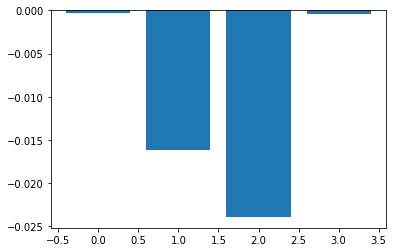


Component:
 Feature: PFD_HOME, Score: 0.03437
 Feature: PCT_PTS_FT_HOME, Score: 0.00009
 Feature: FTA_RATE_HOME, Score: 0.00013
 Feature: FTM_HOME, Score: 0.00406
 Feature: FTA_HOME, Score: 0.01189


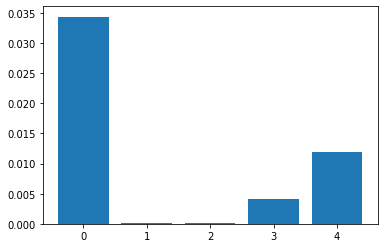


Component:
 Feature: NET_RATING_HOME, Score: -0.03962
 Feature: PLUS_MINUS_HOME, Score: -0.04815


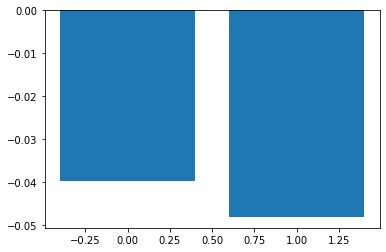


Component:
 Feature: PF_HOME, Score: -0.00965
 Feature: OPP_FTA_RATE_HOME, Score: -0.00043


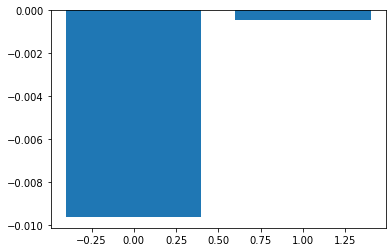


Component:
 Feature: OPP_PTS_2ND_CHANCE_HOME, Score: 0.02832
 Feature: OPP_OREB_PCT_HOME, Score: 0.00052


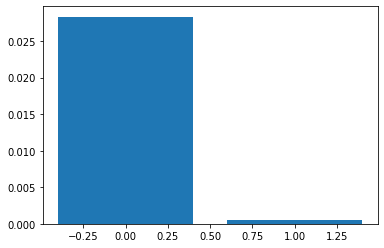


Component:
 Feature: TM_TOV_PCT_HOME, Score: 0.01061
 Feature: OPP_PTS_OFF_TOV_HOME, Score: 0.00357
 Feature: TO_HOME, Score: 0.01825


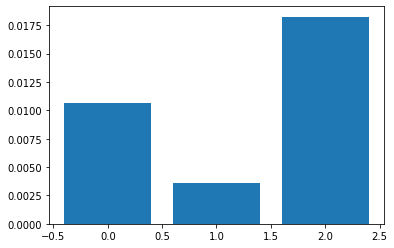


Component:
 Feature: STL_HOME, Score: 0.02004
 Feature: OPP_TOV_PCT_HOME, Score: 0.00048
 Feature: PCT_PTS_OFF_TOV_HOME, Score: 0.00045
 Feature: PTS_OFF_TOV_HOME, Score: 0.03643


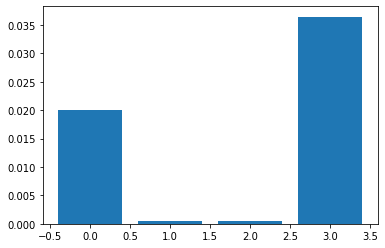


Component:
 Feature: PCT_FGA_2PT_HOME, Score: 0.00049
 Feature: PCT_PTS_2PT_HOME, Score: 0.00051


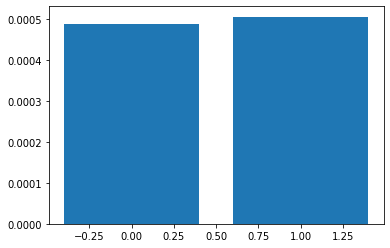


Component:
 Feature: PCT_UAST_FGM_HOME, Score: 0.00080
 Feature: PCT_UAST_2PM_HOME, Score: 0.00087


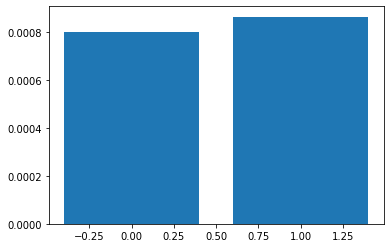


Component:
 Feature: AST_AWAY, Score: 0.02074
 Feature: AST_RATIO_AWAY, Score: 0.01531
 Feature: PCT_AST_2PM_AWAY, Score: 0.00021
 Feature: AST_PCT_AWAY, Score: 0.00026
 Feature: PCT_AST_FGM_AWAY, Score: 0.00026


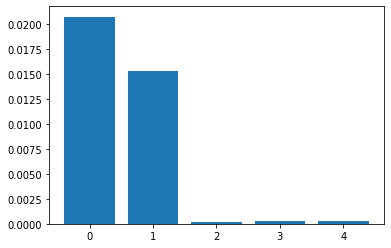


Component:
 Feature: PCT_PTS_PAINT_AWAY, Score: 0.00005
 Feature: PTS_PAINT_AWAY, Score: 0.01487
 Feature: CFGM_AWAY, Score: 0.00707
 Feature: CFGA_AWAY, Score: -0.01430


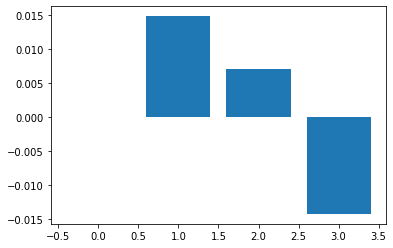


Component:
 Feature: OPP_PTS_PAINT_AWAY, Score: 0.00118
 Feature: DFGM_AWAY, Score: -0.02027
 Feature: DFGA_AWAY, Score: -0.04020


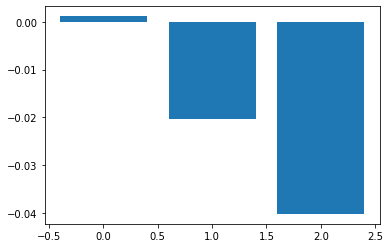


Component:
 Feature: PCT_FGA_3PT_AWAY, Score: 0.00040
 Feature: FG3M_AWAY, Score: 0.01244
 Feature: FG3A_AWAY, Score: 0.03067
 Feature: PCT_PTS_3PT_AWAY, Score: 0.00028


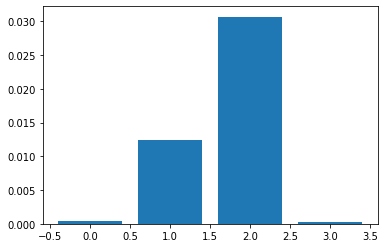


Component:
 Feature: PCT_PTS_FT_AWAY, Score: -0.00030
 Feature: PFD_AWAY, Score: -0.00943
 Feature: FTM_AWAY, Score: -0.02757
 Feature: FTA_AWAY, Score: -0.01985
 Feature: FTA_RATE_AWAY, Score: -0.00013


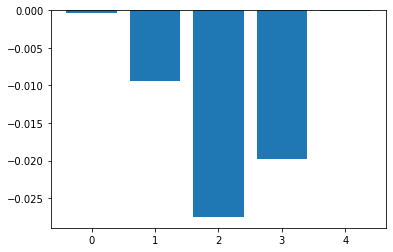


Component:
 Feature: PLUS_MINUS_AWAY, Score: 0.04084
 Feature: NET_RATING_AWAY, Score: 0.03979


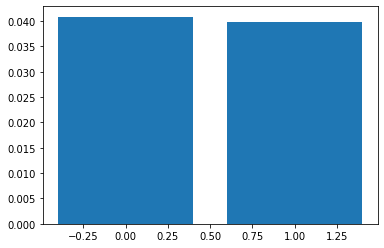


Component:
 Feature: PF_AWAY, Score: 0.00701
 Feature: OPP_FTA_RATE_AWAY, Score: 0.00006


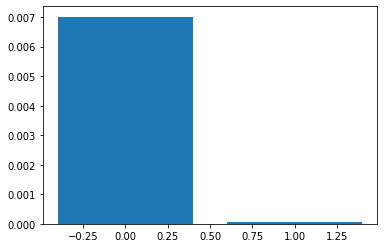


Component:
 Feature: OPP_PTS_OFF_TOV_AWAY, Score: 0.02208
 Feature: TM_TOV_PCT_AWAY, Score: 0.00176
 Feature: TO_AWAY, Score: -0.00432


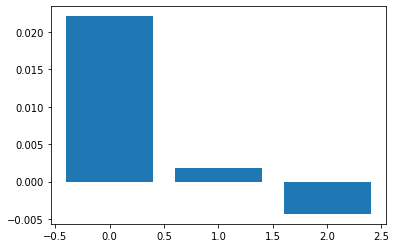


Component:
 Feature: OPP_TOV_PCT_AWAY, Score: -0.00003
 Feature: PCT_PTS_OFF_TOV_AWAY, Score: -0.00010
 Feature: PTS_OFF_TOV_AWAY, Score: -0.00588
 Feature: STL_AWAY, Score: -0.01774


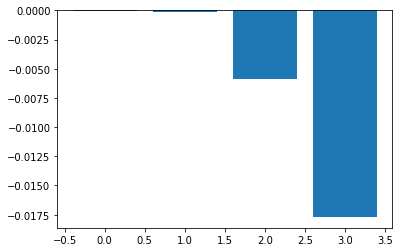


Component:
 Feature: PCT_FGA_2PT_AWAY, Score: -0.00049
 Feature: PCT_PTS_2PT_AWAY, Score: -0.00008


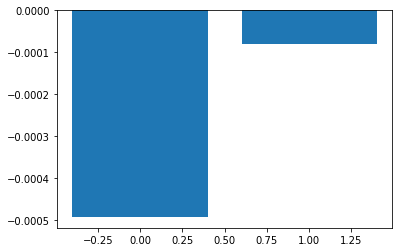


Component:
 Feature: PCT_UAST_2PM_AWAY, Score: -0.00031
 Feature: PCT_UAST_FGM_AWAY, Score: -0.00036


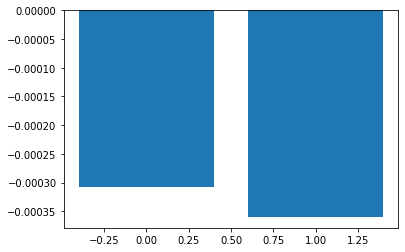


Component:
 Feature: UFGA_AWAY, Score: -0.00926
 Feature: UFGM_AWAY, Score: 0.00564


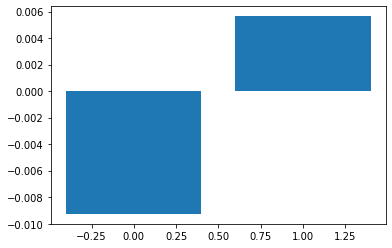

In [17]:
components_imp = []
for component in components:
    if len(component) != 1:
        tmp = []
        print("\nComponent:")
        for feature in component:
            value = importance[X.columns.get_loc(feature)]
            print(' Feature: %s, Score: %.5f' % (feature,value))
            tmp.append(value)
        components_imp.append(tmp)
            
        plt.bar([x for x in range(len(tmp))], tmp)
        plt.show()

In [18]:
X_removed_corr = copy.deepcopy(X)
X_test_removed_corr = copy.deepcopy(X_test)
n = 0
i = 0
for component in components:
    if len(component) != 1:
        max_value = round(max(np.abs(components_imp[i])),5)
        i += 1
        for feature in component:
            if abs(importance[X.columns.get_loc(feature)]) < max_value:
                X_removed_corr.drop(feature,axis=1, inplace=True)
                X_test_removed_corr.drop(feature,axis=1, inplace=True)
                print("Removing... "+ str(feature))
                n+=1

Removing... DIST_HOME
Removing... REB_PCT_AWAY
Removing... PASS_HOME
Removing... REB_AWAY
Removing... TS_PCT_HOME
Removing... UFG_PCT_HOME
Removing... FGM_HOME
Removing... TS_PCT_AWAY
Removing... OREB_HOME
Removing... DREB_HOME
Removing... FT_PCT_HOME
Removing... OPP_EFG_PCT_HOME
Removing... DREB_PCT_AWAY
Removing... FGA_HOME
Removing... FGA_AWAY
Removing... FGM_AWAY
Removing... OREB_AWAY
Removing... PTS_2ND_CHANCE_AWAY
Removing... OFF_RATING_HOME
Removing... DFG_PCT_HOME
Removing... PACE_AWAY
Removing... PACE_HOME
Removing... USG_PCT_AWAY
Removing... ORBC_AWAY
Removing... AST_HOME
Removing... CFG_PCT_HOME
Removing... PIE_HOME
Removing... DREB_PCT_HOME
Removing... TCHS_HOME
Removing... REB_PCT_HOME
Removing... DRBC_HOME
Removing... USG_PCT_HOME
Removing... DEF_RATING_AWAY
Removing... FG_PCT_HOME
Removing... DFG_PCT_AWAY
Removing... OFF_RATING_AWAY
Removing... REB_HOME
Removing... DFGM_HOME
Removing... EFG_PCT_AWAY
Removing... OREB_PCT_HOME
Removing... FG3_PCT_AWAY
Removing... AST_RATIO

In [19]:
n

128

We have **removed 128 features**. We have 36 feature left.

In [20]:
X_removed_corr

,AST_TOV_HOME,BLKA_HOME,BLK_HOME,FG3A_HOME,FTAST_HOME,OPP_PTS_FB_HOME,PCT_PTS_2PT_MR_HOME,PCT_PTS_FB_HOME,PCT_UAST_3PM_HOME,PFD_HOME,...,PCT_PTS_FB_AWAY,PCT_UAST_3PM_AWAY,PCT_UAST_FGM_AWAY,PF_AWAY,PTS_AWAY,PTS_FB_AWAY,PTS_PAINT_AWAY,SAST_AWAY,TEAM_ABBREVIATION_AWAY,UFGA_AWAY
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.093000,0.000000,0.297000,21.000000,10.000000,107.000000,34.000000,3.000000,15.0,44.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3662,1.686955,5.444444,4.041152,17.584362,1.901235,14.641975,0.190835,0.136877,0.160074,22.139918,...,0.120209,0.152074,0.427205,20.713115,55.454918,57.036885,43.918033,1.848361,18.0,43.852459
3663,1.616461,5.045267,4.679012,22.662551,1.259259,16.156379,0.184679,0.130720,0.230115,19.271605,...,0.117065,0.125286,0.448155,20.085714,52.881633,54.293878,41.583673,2.538776,28.0,43.804082
3664,1.341959,4.538776,4.355102,25.285714,1.310204,15.546939,0.160649,0.165624,0.178465,21.073469,...,0.142328,0.178648,0.381398,21.397541,60.393443,61.008197,38.901639,3.561475,12.0,50.315574
3665,1.704631,4.159836,4.614754,26.913934,1.434426,12.532787,0.187635,0.100484,0.210533,19.622951,...,0.146484,0.176025,0.412914,22.336066,57.741803,59.647541,45.622951,2.577869,7.0,45.659836


In [21]:
X_removed_corr.corr()

,AST_TOV_HOME,BLKA_HOME,BLK_HOME,FG3A_HOME,FTAST_HOME,OPP_PTS_FB_HOME,PCT_PTS_2PT_MR_HOME,PCT_PTS_FB_HOME,PCT_UAST_3PM_HOME,PFD_HOME,...,PCT_PTS_FB_AWAY,PCT_UAST_3PM_AWAY,PCT_UAST_FGM_AWAY,PF_AWAY,PTS_AWAY,PTS_FB_AWAY,PTS_PAINT_AWAY,SAST_AWAY,TEAM_ABBREVIATION_AWAY,UFGA_AWAY
AST_TOV_HOME,1.000000,-0.143727,0.110964,0.256814,0.160038,-0.010228,0.372219,-0.066532,-0.049005,0.229227,...,0.115305,0.102112,0.236550,0.237414,0.305307,0.162957,0.270345,0.113757,0.049769,0.277707
BLKA_HOME,-0.143727,1.000000,0.178219,-0.173266,0.330362,0.341991,-0.103604,0.197572,0.071336,0.291973,...,0.088328,0.043812,0.152022,0.194515,0.160617,0.140514,0.122014,0.080952,0.021720,0.203011
BLK_HOME,0.110964,0.178219,1.000000,0.140123,0.167224,0.061227,0.051451,0.246121,0.225430,0.290795,...,0.119850,0.067370,0.199092,0.220418,0.218431,0.146176,0.181986,0.070528,0.046003,0.233334
FG3A_HOME,0.256814,-0.173266,0.140123,1.000000,-0.046745,0.264645,-0.286632,0.362910,0.250880,0.348462,...,0.106789,0.053837,0.192026,0.209918,0.220237,0.171090,0.229834,0.090726,0.044448,0.234225
FTAST_HOME,0.160038,0.330362,0.167224,-0.046745,1.000000,0.175544,-0.126582,0.226947,-0.058324,0.525832,...,0.101221,0.079576,0.191620,0.190340,0.197389,0.121146,0.144371,0.055084,0.059381,0.215130
OPP_PTS_FB_HOME,-0.010228,0.341991,0.061227,0.264645,0.175544,1.000000,-0.082875,0.419439,0.188170,0.322023,...,0.140501,0.085954,0.213291,0.286286,0.227999,0.231563,0.241445,0.104431,0.067809,0.265646
PCT_PTS_2PT_MR_HOME,0.372219,-0.103604,0.051451,-0.286632,-0.126582,-0.082875,1.000000,-0.353198,0.080345,-0.049797,...,0.091983,0.044507,0.145831,0.183428,0.140989,0.122472,0.147329,0.064909,0.011262,0.165522
PCT_PTS_FB_HOME,-0.066532,0.197572,0.246121,0.362910,0.226947,0.419439,-0.353198,1.000000,0.174597,0.362801,...,0.085780,0.065123,0.159622,0.185270,0.144079,0.156211,0.153402,0.057614,0.049211,0.191478
PCT_UAST_3PM_HOME,-0.049005,0.071336,0.225430,0.250880,-0.058324,0.188170,0.080345,0.174597,1.000000,0.223703,...,0.062149,0.007549,0.090482,0.103152,0.151418,0.059480,0.117572,0.051515,0.037132,0.132748
PFD_HOME,0.229227,0.291973,0.290795,0.348462,0.525832,0.322023,-0.049797,0.362801,0.223703,1.000000,...,0.208382,0.136685,0.344041,0.389866,0.381872,0.270738,0.329356,0.145278,0.072709,0.415133


In [22]:
pairs(X_removed_corr)[0]

{}

In [23]:
log_model_rc = LogisticRegression()
log_model_rc.fit(X_removed_corr, y['0'].values.tolist())
log_model_rc.score(X_test_removed_corr, y_test['0'].values.tolist())

0.6113821138211382

**New accuracy score is 61.14%.**

Accuracy has dropped for a small amount considering we have removed 128/164 features. Now, the model is a lot easier to interpret.

It should also be noted that using logistic regression coef as a means to determine the importance of a feature may not be the best solution. Especially when the coef are close in value. Some other methods that should be explored are: Decision Tree Feature Importance with CART, Random Forest Feature Importance or XGBoost Feature Importance, Permutation Feature Importance,etc.

# 5. New features

Since there is a small amount of features left and I am not versed in basketball statistics new features will not be anything quite imaginative.

**Feature 1**
= BLK_HOME/BLKA_HOME </br>
Indicates a ratio of how many blocks were successful.

**Feature 2**
= PF_HOME/PF_AWAY </br>
Indicates a ratio of fouls given by each team.

**Feature 3**
= PTS_HOME/DFGA_AWAY </br>
Indicates a ratio of how many goals away team was able to defend.

In [24]:
X_corr_nf = copy.deepcopy(X_removed_corr)
X_test_corr_nf = copy.deepcopy(X_test_removed_corr)

In [25]:
X_corr_nf['BLK_SUCC_HOME'] = X_corr_nf['BLK_HOME'] / X_corr_nf['BLKA_HOME']
X_corr_nf['BLK_SUCC_AWAY'] = X_corr_nf['BLK_AWAY'] / X_corr_nf['BLKA_AWAY']

X_test_corr_nf['BLK_SUCC_HOME'] = X_test_corr_nf['BLK_HOME'] / X_test_corr_nf['BLKA_HOME']
X_test_corr_nf['BLK_SUCC_AWAY'] = X_test_corr_nf['BLK_AWAY'] / X_test_corr_nf['BLKA_AWAY']

In [26]:
X_corr_nf['PF_RATIO'] = X_corr_nf['PF_HOME'] / X_corr_nf['PF_AWAY']

X_test_corr_nf['PF_RATIO'] = X_test_corr_nf['PF_HOME'] / X_test_corr_nf['PF_AWAY']

In [27]:
X_corr_nf['DF_SUCC_AWAY'] = X_corr_nf['PTS_HOME'] / X_corr_nf['DFGA_AWAY']

X_test_corr_nf['DF_SUCC_AWAY'] = X_test_corr_nf['PTS_HOME'] / X_test_corr_nf['DFGA_AWAY']

In [28]:
X_corr_nf.drop('BLK_HOME',axis=1, inplace=True)
X_corr_nf.drop('BLKA_HOME',axis=1, inplace=True)
X_corr_nf.drop('BLK_AWAY',axis=1, inplace=True)
X_corr_nf.drop('BLKA_AWAY',axis=1, inplace=True)

X_corr_nf.drop('PF_HOME',axis=1, inplace=True)
X_corr_nf.drop('PF_AWAY',axis=1, inplace=True)

X_corr_nf.drop('PTS_HOME',axis=1, inplace=True)
X_corr_nf.drop('DFGA_AWAY',axis=1, inplace=True)


X_test_corr_nf.drop('BLK_HOME',axis=1, inplace=True)
X_test_corr_nf.drop('BLKA_HOME',axis=1, inplace=True)
X_test_corr_nf.drop('BLK_AWAY',axis=1, inplace=True)
X_test_corr_nf.drop('BLKA_AWAY',axis=1, inplace=True)

X_test_corr_nf.drop('PF_HOME',axis=1, inplace=True)
X_test_corr_nf.drop('PF_AWAY',axis=1, inplace=True)

X_test_corr_nf.drop('PTS_HOME',axis=1, inplace=True)
X_test_corr_nf.drop('DFGA_AWAY',axis=1, inplace=True)

X_corr_nf.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_corr_nf.replace([np.inf, -np.inf], np.nan, inplace=True)
X_corr_nf = X_corr_nf.fillna(0)
X_test_corr_nf = X_test_corr_nf.fillna(0)

In [29]:
X_corr_nf

,AST_TOV_HOME,FG3A_HOME,FTAST_HOME,OPP_PTS_FB_HOME,PCT_PTS_2PT_MR_HOME,PCT_PTS_FB_HOME,PCT_UAST_3PM_HOME,PFD_HOME,PTS_FB_HOME,SAST_HOME,...,PTS_AWAY,PTS_FB_AWAY,PTS_PAINT_AWAY,SAST_AWAY,TEAM_ABBREVIATION_AWAY,UFGA_AWAY,BLK_SUCC_HOME,BLK_SUCC_AWAY,PF_RATIO,DF_SUCC_AWAY
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,107.000000,34.000000,3.000000,15.0,44.000000,0.000000,1.750000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3662,1.686955,17.584362,1.901235,14.641975,0.190835,0.136877,0.160074,22.139918,58.469136,2.736626,...,55.454918,57.036885,43.918033,1.848361,18.0,43.852459,0.742252,0.986341,0.937161,2.375375
3663,1.616461,22.662551,1.259259,16.156379,0.184679,0.130720,0.230115,19.271605,56.662551,2.246914,...,52.881633,54.293878,41.583673,2.538776,28.0,43.804082,0.927406,1.097854,1.019704,2.395143
3664,1.341959,25.285714,1.310204,15.546939,0.160649,0.165624,0.178465,21.073469,59.820408,2.224490,...,60.393443,61.008197,38.901639,3.561475,12.0,50.315574,0.959532,1.606914,1.027202,2.665141
3665,1.704631,26.913934,1.434426,12.532787,0.187635,0.100484,0.210533,19.622951,56.696721,3.049180,...,57.741803,59.647541,45.622951,2.577869,7.0,45.659836,1.109360,0.828104,0.882385,2.440935


In [30]:
X_test_corr_nf

,AST_TOV_HOME,FG3A_HOME,FTAST_HOME,OPP_PTS_FB_HOME,PCT_PTS_2PT_MR_HOME,PCT_PTS_FB_HOME,PCT_UAST_3PM_HOME,PFD_HOME,PTS_FB_HOME,SAST_HOME,...,PTS_AWAY,PTS_FB_AWAY,PTS_PAINT_AWAY,SAST_AWAY,TEAM_ABBREVIATION_AWAY,UFGA_AWAY,BLK_SUCC_HOME,BLK_SUCC_AWAY,PF_RATIO,DF_SUCC_AWAY
0,1.704631,26.913934,1.434426,12.532787,0.187635,0.100484,0.210533,19.622951,56.696721,3.049180,...,53.053279,54.139344,41.557377,2.536885,28.0,43.790984,1.109360,1.097163,0.980428,2.512564
1,1.920288,27.773663,1.580247,13.942387,0.144444,0.170160,0.204267,19.279835,64.777778,3.485597,...,57.061728,58.460905,44.831276,4.069959,26.0,46.440329,1.430353,1.275335,1.142244,2.771505
2,1.594467,20.336066,1.225410,12.926230,0.198242,0.117824,0.164824,18.172131,53.741803,2.565574,...,53.510288,56.942387,43.736626,3.020576,15.0,42.637860,0.810319,1.330499,1.078502,2.459922
3,1.560246,21.016393,1.454918,12.327869,0.207221,0.107844,0.169070,21.274590,54.217213,2.922131,...,59.115226,57.864198,40.831276,3.148148,6.0,48.279835,1.077748,1.065831,1.043582,2.380814
4,1.782787,23.954918,1.590164,11.692623,0.188328,0.138086,0.139020,19.614754,57.647541,2.540984,...,53.855967,54.358025,43.135802,2.596708,1.0,42.201646,0.787903,0.866128,1.091127,2.330307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,1.457774,22.689024,1.939024,12.621951,0.146927,0.108253,0.142841,20.003049,53.271341,3.210366,...,57.587156,58.373089,43.492355,4.614679,26.0,45.058104,1.141892,1.319625,1.082815,2.204998
1226,1.987003,26.229358,1.685015,12.474006,0.185092,0.138453,0.185627,22.464832,60.819572,3.862385,...,58.344615,58.381538,45.372308,2.932308,25.0,42.532308,1.540230,0.729029,1.001908,2.591546
1227,1.988988,28.705521,1.840491,14.049080,0.142018,0.176669,0.194040,19.297546,65.840491,5.049080,...,57.153374,57.196319,41.730061,2.855828,13.0,42.527607,1.518809,0.875825,0.994919,2.471224
1228,1.699358,27.140673,1.636086,12.584098,0.177459,0.101706,0.211657,19.666667,57.088685,3.510703,...,56.432515,57.794479,43.969325,2.613497,18.0,43.662577,1.061983,1.049454,0.999989,2.307178


## 6. Run the cross-validation function

In [31]:
cross_validation_function(pd.concat([X_corr_nf, X_test_corr_nf], axis=0),list(map(int, y['0'].values.tolist()+ y_test['0'].values.tolist())))

[21:52:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,Algorithm,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
0,GaussianNB,0.586735,0.504082,0.475996,0.475996,0.495403
1,LogisticRegression,0.605102,0.635714,0.640449,0.670072,0.617978
2,RIPPER,0.557143,0.597959,0.592441,0.586313,0.588355
3,RandomForestClassifier,0.610204,0.657143,0.653728,0.660878,0.640449
4,ExtraTreesClassifier,0.622449,0.640816,0.635342,0.646578,0.624106
5,XGBClassifier,0.586735,0.647959,0.613892,0.646578,0.618999


Again, Logisitic Regression gives the best result.

In [32]:
log_model_rc = LogisticRegression()
log_model_rc.fit(X_corr_nf, y['0'].values.tolist())
log_model_rc.score(X_test_corr_nf, y_test['0'].values.tolist())

0.6178861788617886

**New accuracy score is 61.79%.** </br>
Accuracy score has improved just a bit.

# 7. Filter method

In [33]:
model_fm = LogisticRegression()
scores = []

In [34]:
ft_5 = SelectKBest(f_classif, k=5).fit(X_corr_nf, y['0'].values.tolist()).get_feature_names_out()

In [35]:
data_5 = X_corr_nf[ft_5]
data_test_5 = X_test_corr_nf[ft_5]

In [36]:
score = cross_val_score(model_fm, pd.concat([data_5, data_test_5], axis=0),list(map(int, y['0'].values.tolist()+ y_test['0'].values.tolist())), cv=5, scoring='accuracy')
scores.append(np.mean(score))

In [37]:
ft_10 = SelectKBest(f_classif, k=10).fit(X_corr_nf, y['0'].values.tolist()).get_feature_names_out()

In [38]:
data_10 = X_corr_nf[ft_10]
data_test_10 = X_test_corr_nf[ft_10]

In [39]:
score = cross_val_score(model_fm, pd.concat([data_10, data_test_10], axis=0),list(map(int, y['0'].values.tolist()+ y_test['0'].values.tolist())), cv=5, scoring='accuracy')
scores.append(np.mean(score))

In [40]:
ft_15 = SelectKBest(f_classif, k=15).fit(X_corr_nf, y['0'].values.tolist()).get_feature_names_out()
data_15 = X_corr_nf[ft_15]
data_test_15 = X_test_corr_nf[ft_15]
score = cross_val_score(model_fm, pd.concat([data_15, data_test_15], axis=0),list(map(int, y['0'].values.tolist()+ y_test['0'].values.tolist())), cv=5, scoring='accuracy')
scores.append(np.mean(score))

In [41]:
ft_20 = SelectKBest(f_classif, k=20).fit(X_corr_nf, y['0'].values.tolist()).get_feature_names_out()
data_20 = X_corr_nf[ft_20]
data_test_20 = X_test_corr_nf[ft_20]
score = cross_val_score(model_fm, pd.concat([data_20, data_test_20], axis=0),list(map(int, y['0'].values.tolist()+ y_test['0'].values.tolist())), cv=5, scoring='accuracy')
scores.append(np.mean(score))

In [42]:
ft_25 = SelectKBest(f_classif, k=25).fit(X_corr_nf, y['0'].values.tolist()).get_feature_names_out()
data_25 = X_corr_nf[ft_25]
data_test_25 = X_test_corr_nf[ft_25]
score = cross_val_score(model_fm, pd.concat([data_25, data_test_25], axis=0),list(map(int, y['0'].values.tolist()+ y_test['0'].values.tolist())), cv=5, scoring='accuracy')
scores.append(np.mean(score))

In [43]:
ft_30 = SelectKBest(f_classif, k=30).fit(X_corr_nf, y['0'].values.tolist()).get_feature_names_out()
data_30 = X_corr_nf[ft_30]
data_test_30 = X_test_corr_nf[ft_30]
score = cross_val_score(model_fm, pd.concat([data_30, data_test_30], axis=0),list(map(int, y['0'].values.tolist()+ y_test['0'].values.tolist())), cv=5, scoring='accuracy')
scores.append(np.mean(score))

In [44]:
ft_32 = SelectKBest(f_classif, k=32).fit(X_corr_nf, y['0'].values.tolist()).get_feature_names_out()
data_32 = X_corr_nf[ft_32]
data_test_32 = X_test_corr_nf[ft_32]
score = cross_val_score(model_fm, pd.concat([data_32, data_test_32], axis=0),list(map(int, y['0'].values.tolist()+ y_test['0'].values.tolist())), cv=5, scoring='accuracy')
scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy')

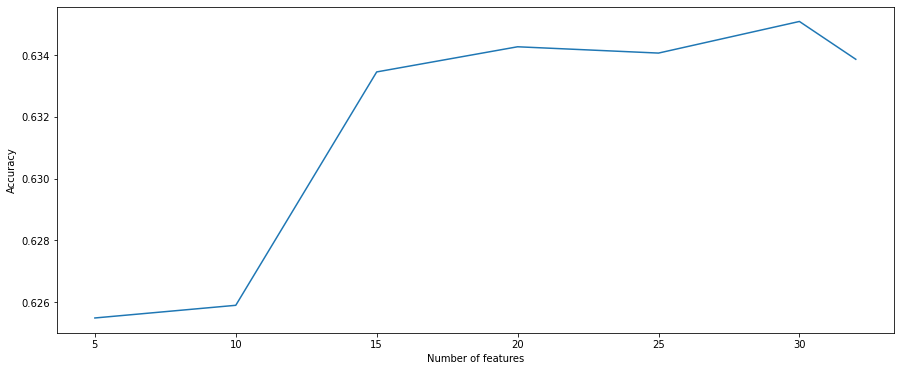

In [45]:
plt.figure(figsize=(15,6))
plt.plot([5,10,15,20,25,30,32], scores)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')

Selecting 30 out of 32 features gives the best accuracy.

In [46]:
data_30

,AST_TOV_HOME,FG3A_HOME,FTAST_HOME,OPP_PTS_FB_HOME,PCT_PTS_2PT_MR_HOME,PCT_PTS_FB_HOME,PCT_UAST_3PM_HOME,PFD_HOME,PTS_FB_HOME,SAST_HOME,...,PTS_AWAY,PTS_FB_AWAY,PTS_PAINT_AWAY,SAST_AWAY,TEAM_ABBREVIATION_AWAY,UFGA_AWAY,BLK_SUCC_HOME,BLK_SUCC_AWAY,PF_RATIO,DF_SUCC_AWAY
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,107.000000,34.000000,3.000000,15.0,44.000000,0.000000,1.750000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3662,1.686955,17.584362,1.901235,14.641975,0.190835,0.136877,0.160074,22.139918,58.469136,2.736626,...,55.454918,57.036885,43.918033,1.848361,18.0,43.852459,0.742252,0.986341,0.937161,2.375375
3663,1.616461,22.662551,1.259259,16.156379,0.184679,0.130720,0.230115,19.271605,56.662551,2.246914,...,52.881633,54.293878,41.583673,2.538776,28.0,43.804082,0.927406,1.097854,1.019704,2.395143
3664,1.341959,25.285714,1.310204,15.546939,0.160649,0.165624,0.178465,21.073469,59.820408,2.224490,...,60.393443,61.008197,38.901639,3.561475,12.0,50.315574,0.959532,1.606914,1.027202,2.665141
3665,1.704631,26.913934,1.434426,12.532787,0.187635,0.100484,0.210533,19.622951,56.696721,3.049180,...,57.741803,59.647541,45.622951,2.577869,7.0,45.659836,1.109360,0.828104,0.882385,2.440935


## 8. Run the cross-validation function

In [47]:
cross_validation_function(pd.concat([data_30, data_test_30], axis=0),list(map(int, y['0'].values.tolist()+ y_test['0'].values.tolist())))

[21:53:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:53:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:53:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:53:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,Algorithm,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
0,GaussianNB,0.591837,0.506122,0.479060,0.477017,0.501532
1,LogisticRegression,0.610204,0.638776,0.641471,0.665986,0.618999
2,RIPPER,0.558163,0.586735,0.606742,0.621042,0.578141
3,RandomForestClassifier,0.591837,0.658163,0.628192,0.660878,0.643514
4,ExtraTreesClassifier,0.635714,0.644898,0.635342,0.641471,0.639428
5,XGBClassifier,0.596939,0.639796,0.624106,0.647600,0.628192


# 9. Explainability with SHAP

In [48]:
model_shap = XGBClassifier()
model_shap.fit(data_30, y['0'].values.tolist())

[21:53:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
shap_explainer = shap.TreeExplainer(model_shap)

In [50]:
shap_vals = shap_explainer.shap_values(data_30)

In [51]:
team_rows = data.loc[(data['TEAM_ABBREVIATION_HOME'] == 19)]

In [52]:
last_games = team_rows.index[-10:]
last_games = [x-1 for x in last_games]
team_data = data_30.iloc[last_games]
team_data

,AST_TOV_HOME,FG3A_HOME,FTAST_HOME,OPP_PTS_FB_HOME,PCT_PTS_2PT_MR_HOME,PCT_PTS_FB_HOME,PCT_UAST_3PM_HOME,PFD_HOME,PTS_FB_HOME,SAST_HOME,...,PTS_AWAY,PTS_FB_AWAY,PTS_PAINT_AWAY,SAST_AWAY,TEAM_ABBREVIATION_AWAY,UFGA_AWAY,BLK_SUCC_HOME,BLK_SUCC_AWAY,PF_RATIO,DF_SUCC_AWAY
3319,1.645830,22.026906,1.269058,12.062780,0.235906,0.088619,0.159709,19.309417,51.502242,2.645740,...,53.000000,56.307692,42.805430,3.036199,15.0,42.678733,1.210112,1.301865,1.118333,2.377081
3329,1.644420,21.995536,1.263393,12.066964,0.236067,0.088607,0.160482,19.303571,51.303571,2.656250,...,55.802691,59.017937,38.098655,3.125561,24.0,49.816143,1.214765,1.126526,1.097718,2.255822
3359,1.645708,21.995575,1.256637,12.141593,0.236465,0.088146,0.159553,19.274336,51.323009,2.646018,...,56.781250,57.441964,46.982143,2.379464,8.0,42.513393,1.210410,0.943182,1.097823,2.214899
3478,1.653219,21.931330,1.261803,12.231760,0.236283,0.088665,0.159266,19.274678,52.304721,2.686695,...,59.423581,58.126638,46.017467,1.943231,25.0,43.043668,1.222581,0.707317,0.998964,2.315289
3506,1.653617,21.931915,1.263830,12.259574,0.236383,0.088451,0.159583,19.225532,52.374468,2.693617,...,53.832618,54.961373,39.682403,3.236052,4.0,44.090129,1.226013,0.973625,1.134887,2.288352
3522,1.651102,21.966102,1.262712,12.250000,0.236581,0.088555,0.159886,19.203390,52.203390,2.694915,...,55.604255,57.455319,40.595745,3.034043,5.0,45.782979,1.232979,0.793345,1.081918,2.423865
3566,1.652176,21.987448,1.263598,12.280335,0.237209,0.088569,0.159795,19.188285,52.309623,2.690377,...,53.367089,54.607595,43.113924,2.599156,1.0,41.953586,1.229715,0.874883,1.078027,2.147141
3587,1.651167,21.991667,1.262500,12.279167,0.237175,0.088675,0.160321,19.154167,52.141667,2.691667,...,54.233333,55.087500,38.600000,2.900000,11.0,44.700000,1.235542,1.084699,1.027519,2.378211
3605,1.651867,22.004149,1.265560,12.278008,0.236859,0.088734,0.160842,19.149378,51.962656,2.697095,...,53.121339,54.849372,38.150628,3.125523,3.0,44.518828,1.241090,1.002362,1.163913,2.579757
3638,1.651564,21.995885,1.267490,12.271605,0.237099,0.088654,0.159930,19.131687,52.024691,2.703704,...,55.669456,57.682008,41.205021,2.543933,27.0,41.205021,1.245322,0.958442,1.001681,2.258491


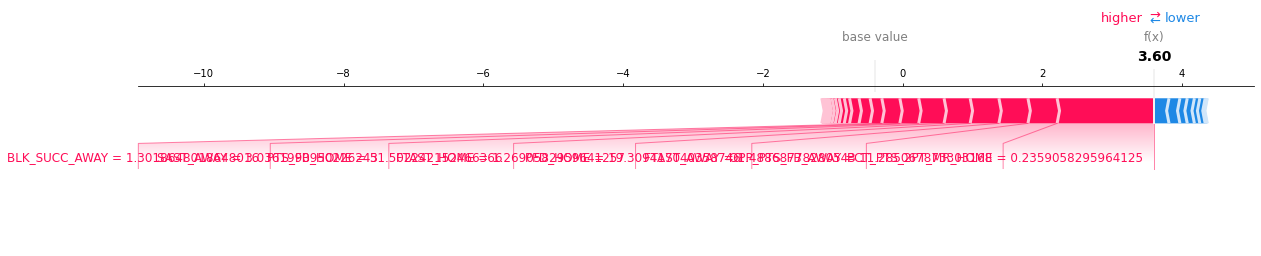

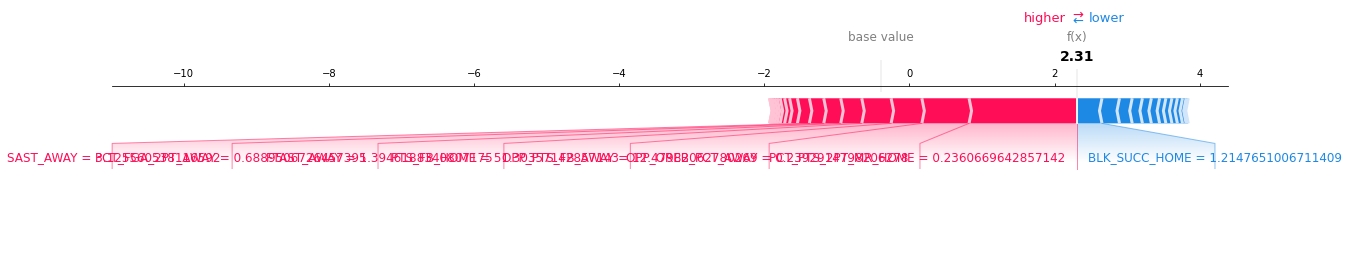

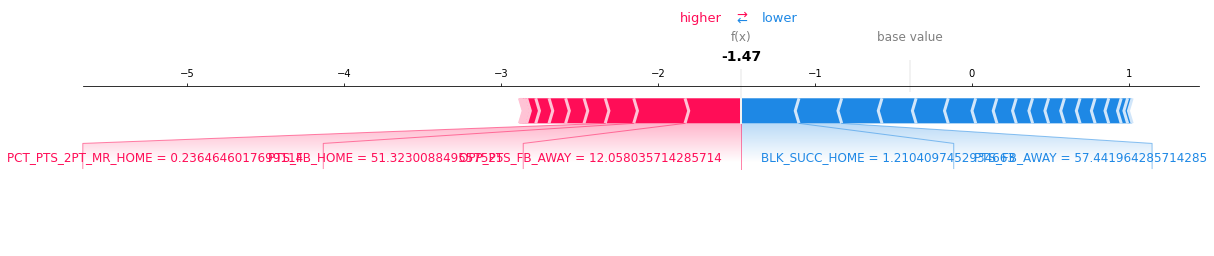

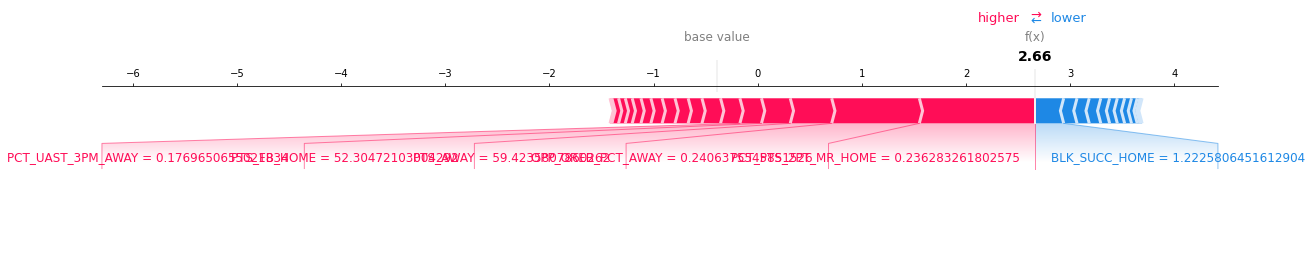

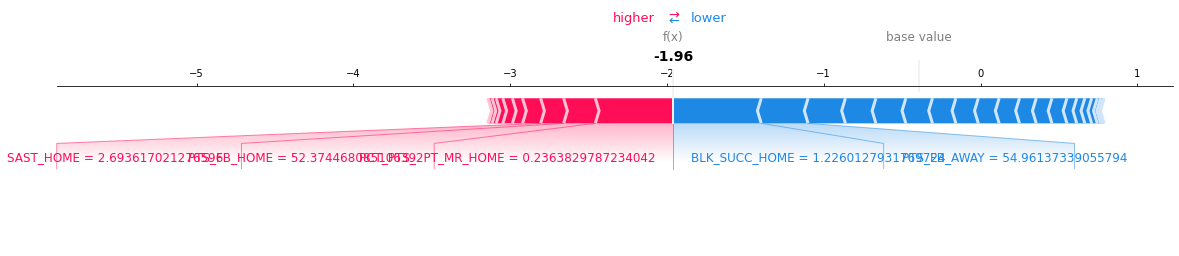

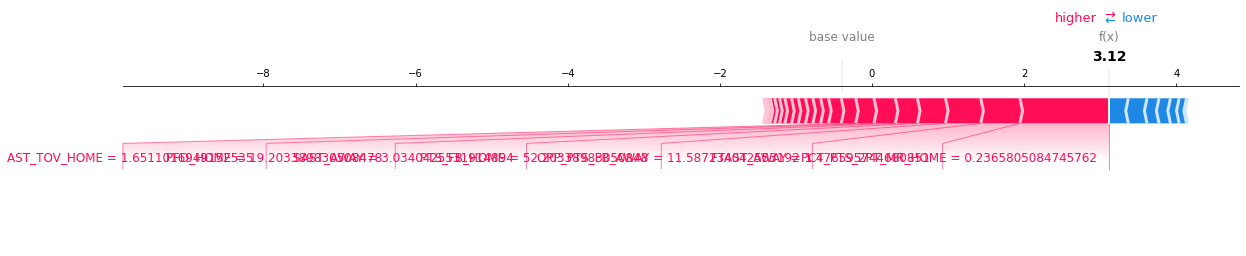

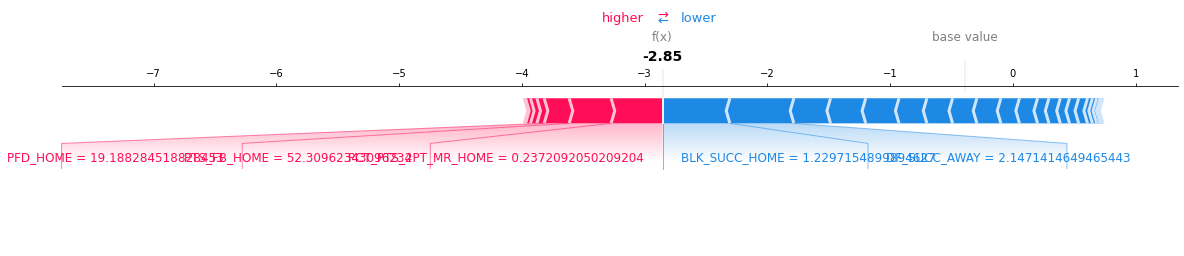

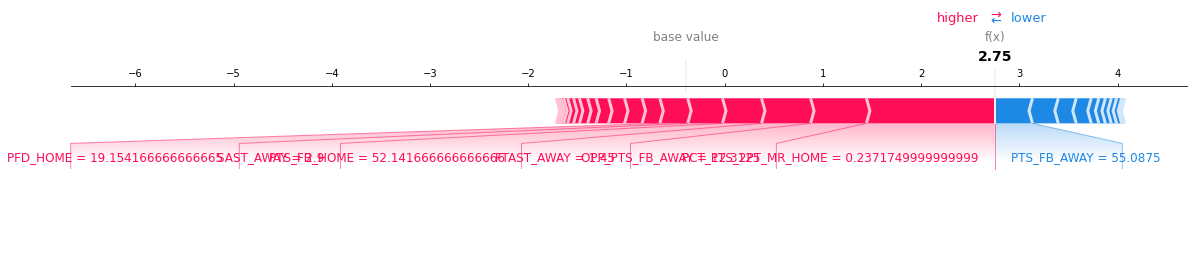

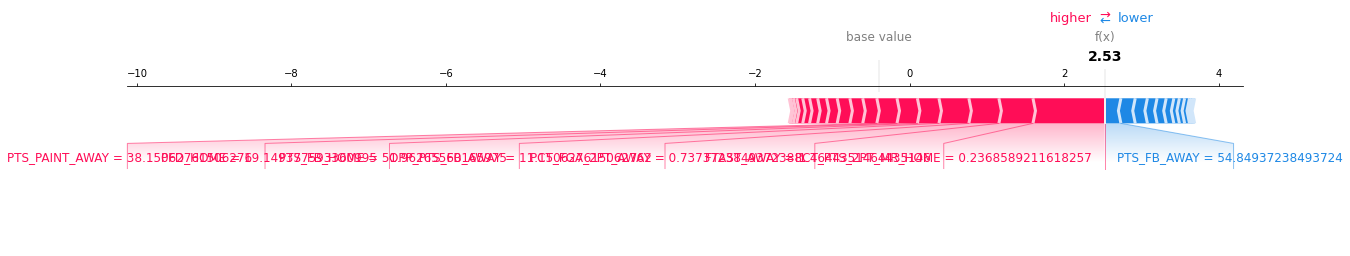

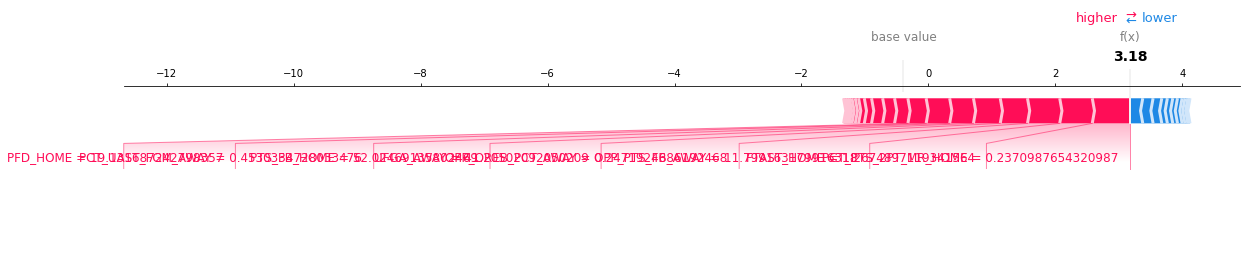

In [53]:
shap.initjs()
for game in last_games:
    shap.force_plot(shap_explainer.expected_value, shap_vals[game,:],data_30.iloc[game, :], matplotlib=True)
    
shap.force_plot(shap_explainer.expected_value, shap_vals[last_games,:],data_30.iloc[last_games, :])

In [54]:
y.iloc[last_games]

,0
3319,1.0
3329,1.0
3359,0.0
3478,1.0
3506,0.0
3522,1.0
3566,0.0
3587,1.0
3605,1.0
3638,1.0


**Important features**</br>
BLK_SUCC_HOME seems to have a big impact on the first 4 games, in a way that it makes them lose the game (blue indicates features that pushed the score lower). For the last 5 games PTS_FB_AWAY has a big impact, as well as PCT_PTS_2PT_MR_HOME. </br>
**Results**</br>
If we look at the graphs, if the bold f(x) value is negative or closer to 0 it means the model predicted 0, on the other hand if the value is positive and closer to 1 than 0 then the model predicted 1. The model predicted accurately all the game outcomes.

# 10. RIPPER optimization

In [55]:
full_dataset = pd.concat([data_30, data_test_30], axis=0)
full_y = list(map(int, y['0'].values.tolist()+ y_test['0'].values.tolist()))

In [56]:
pd_full = pd.DataFrame(full_dataset, columns=data_30.columns)

In [57]:
X_train,X_test,y_train,y_test= train_test_split(pd_full,full_y, test_size=0.33)

In [58]:
ripper_model = lw.RIPPER()
ripper_model.fit(X_train, y_train)

In [59]:
ripper_model.score(X_test, y_test)

0.5837971552257266

In [60]:
ripper_model.ruleset_.out_pretty()

[[SAST_AWAY=>3.85 ^ PCT_UAST_FGM_AWAY=0.376-0.39 ^ PTS_FB_AWAY=58.95-60.41 ^ UFGA_AWAY=46.04-46.86] V
[PTS_AWAY=>60.82 ^ OPP_PTS_FB_AWAY=13.68-14.45]]


**Hyperparameter optimization**

In [61]:
ripper_parameters = {'prune-size':[0.5,0.33,0.2],'k':[1,2] ,'dl_allowance':[64,32]}
ripper_clf = GridSearchCV(ripper_model, ripper_parameters)

In [62]:
ripper_result = ripper_clf.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % ripper_result.best_score_)
print('Best Hyperparameters: %s' % ripper_result.best_params_)

Best Score: 0.6048780487804878
Best Hyperparameters: {'dl_allowance': 32, 'k': 2, 'prune-size': 0.33}


In [63]:
ripper_model = lw.RIPPER(dl_allowance= 32, k= 2, prune_size=0.33)
ripper_model.fit(X_train, y_train)
ripper_model.score(X_test, y_test)

0.5899814471243042

In [64]:
ripper_model.ruleset_.out_pretty()

[[TEAM_ABBREVIATION_HOME=20.0-23.0 ^ SAST_HOME=2.14-2.47 ^ FG3A_HOME=23.98-25.09 ^ PTS_FB_HOME=55.04-56.16] V
[SAST_AWAY=>3.85 ^ AST_TOV_AWAY=>1.9] V
[OPP_PTS_FB_HOME=14.5-15.67]]


**Additional restrictions**

In [65]:
ripper_model = lw.RIPPER(dl_allowance= 32, k= 2, prune_size=0.33, max_rules=3, max_rule_conds=2)
ripper_model.fit(X_train, y_train)
ripper_model.score(X_test, y_test)

0.6060606060606061

In [66]:
ripper_model.ruleset_.out_pretty()

[[BLK_SUCC_AWAY=>1.33 ^ PCT_UAST_FGM_AWAY=<0.376] V
[OPP_PTS_FB_HOME=>15.67] V
[OPP_PTS_FB_HOME=14.5-15.67]]


The ripper algorithm gives poorer results compared to other classification algortihms. </br>
Advantages: give us a well understanding interpretation of the model, works well with numerical predictive features, finds a compact set of useful rules in most situations, works quickly and on a relatively large data set</br>
Dissadvantage: if the problem is complex (conditions cover a small number of copies), there is no guarantee that they will find useful rules
